In [5]:
import copy
import numpy as np
from Functions import plot_multiple_line

import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)


def plot_multiple_line(ax, x, data, color, alpha=0.1, subsample=1, **kwargs):
    num = data.shape[0]
    if len(x.shape) == 1:
        avg = np.mean(data, axis=0)
        ax.plot(x[::subsample], avg[::subsample], color=color, **kwargs)
        for i in range(num):
            ax.fill_between(
                x[::subsample],
                data[i, ::subsample],
                avg[::subsample],
                color=color,
                alpha=alpha,
                linewidth=0,
            )

    else:
        mean_x_axis = np.unique(x.ravel())
        ys_interp = [np.interp(mean_x_axis, x[i, :], data[i, :])
                     for i in range(num)]
        avg = np.mean(ys_interp, axis=0)
        ax.plot(mean_x_axis[::subsample],
                avg[::subsample], color=color, **kwargs)

        for i in range(num):
            # ax.plot(x[i], data[i], color=color, alpha=alpha, linewidth=0.5)
            ax.fill_between(
                mean_x_axis[::subsample],
                ys_interp[i][::subsample],
                avg[::subsample],
                color=color,
                alpha=alpha,
                linewidth=0,
            )


In [6]:
# Define functions


def val_g(x, noise_level=0):
    result = np.array(
        [x[0] + 3 * x[1], 2 * x[0] ** 2 - x[1], x[0] ** 2 - x[0] * x[1] ** 2]
    ) + noise_level * 5 * np.random.normal(size=3)
    return result


def val_f(u, noise_level=0):
    result = (
        u[0] ** 2
        - u[1] ** 2
        + u[0] * u[1] * u[2]
        + u[2] ** 2
        + noise_level * np.random.normal(size=1)
    )
    return result


def val_g_batch(x, noise_level, batch_g):
    result = np.zeros(3)
    for _ in range(batch_g):
        result = result + val_g(x, noise_level)
    result = result / batch_g
    return result


def val_F_d(x):
    return val_f(val_g(x))


def grad_g(x, noise_level=0):
    result = np.array(
        [[1, 3], [4 * x[0], -1], [2 * x[0] - x[1] ** 2, -2 * x[0] * x[1]]]
    ) + noise_level * np.random.normal(size=[3, 2])
    return result


def grad_f(u, noise_level=0):
    result = np.array(
        [2 * u[0] + u[1] * u[2], 2 * u[1] + u[0] * u[2], 2 * u[2] + u[0] * u[1]]
    ) + noise_level * np.random.normal(size=3)
    return result


def grad_F_d(x):  # determinastic \grad F
    result = np.dot(grad_g(x).T, grad_f(val_g(x)))
    return result

In [7]:
# Fitting h_b and h_v
eta = np.linspace(1, 300, 30, dtype=int)
noise = 5
sample_size = 6000

np.random.seed(8)
x = np.random.rand(2)

grad_F_infty = grad_F_d(x)

sample_variance = np.zeros([len(eta), len(x)])
sample_mean = np.zeros([len(eta), len(x)])
for i in range(len(eta)):
    batch_g = eta[i]
    grad_F_sample = np.zeros([sample_size, len(x)])

    for j in range(sample_size):
        temp = np.dot(grad_g(x, noise).T, grad_f(val_g_batch(x, noise, batch_g), noise))
        grad_F_sample[j, :] = temp

    sample_variance[i, :] = np.var(grad_F_sample, axis=0)
    sample_mean[i, :] = np.mean(grad_F_sample, axis=0)
    print(eta[i], end="\r")

Estimate the variance bound as $M_1\eta^{-a}+b$

/var/folders/vf/h86_x6wn50nfrb55z925rsrh0000gn/T/ipykernel_95092/2362376598.py:5: RuntimeWarning: overflow encountered in power
  return M_1 * eta ** (-a) + b


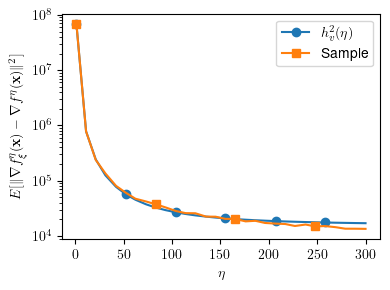

In [9]:
from scipy.optimize import curve_fit


def bound_var(eta, M_1, a, b):
    return M_1 * eta ** (-a) + b


plt.figure(figsize=(4, 3))
popt_var, pcov_var = curve_fit(bound_var, eta, np.sum(sample_variance, axis=1))
plt.plot(
    eta, bound_var(eta, *popt_var), label=r"$h_v^2(\eta)$", marker="o", markevery=5
)

plt.plot(eta, np.sum(sample_variance, axis=1), label="Sample", marker="s", markevery=8)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$E[\|\nabla f^{\eta}_\xi(\mathbf{x})- \nabla f^{\eta}(\mathbf{x})\|^2]$")
plt.yscale("log")
plt.legend()

plt.tight_layout()

plt.savefig("Figure/non_cvx_var_fit.pdf", bbox_inches="tight")

Estimate bias bound as $M_2\eta^{-a}+b$

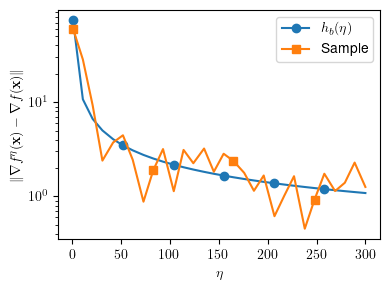

In [10]:
def bound_bias(eta, M_2, a, b):
    return M_2 * eta ** (-a) + b


popt_bias, pcov_bias = curve_fit(
    bound_bias, eta, np.log10(np.linalg.norm(sample_mean - grad_F_infty, axis=1) ** 2)
)

plt.figure(figsize=(4, 3))

plt.plot(
    eta,
    np.sqrt(10 ** bound_bias(eta, *popt_bias)),
    label=r"$h_b(\eta)$",
    marker="o",
    markevery=5,
)
plt.plot(
    eta,
    np.linalg.norm(sample_mean - grad_F_infty, axis=1),
    label="Sample",
    marker="s",
    markevery=8,
)
plt.yscale("log")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\| \nabla f^\eta(\mathbf{x}) - \nabla f(\mathbf{x})\|$")
plt.legend()

plt.tight_layout()

plt.savefig("Figure/non_cvx_bias_fit.pdf", bbox_inches="tight")

## B-SGD

In [ ]:
np.random.seed(8)
x_init = np.random.rand(2)
noise = 5
# BSGD
num_iter = 1000
alpha = 0.001
num_exp = 20
batch_g_max = 300
batch_grad = 1000

BSGD_valF = np.zeros((num_exp, num_iter + 1))
BSGD_gradF = np.zeros((num_exp, num_iter + 1))
BSGD_batchg = np.zeros((num_exp, num_iter + 1))
for exp in range(num_exp):
    batch_g = batch_g_max
    val_F_iteration_SGD = np.zeros(num_iter + 1)
    grad_F_iteration_SGD = np.zeros(num_iter + 1)
    x_SGD = copy.deepcopy(x_init)
    val_F_iteration_SGD[0] = val_F_d(x_SGD).item()
    grad_F_iteration_SGD[0] = np.linalg.norm(grad_F_d(x_SGD)) ** 2

    for ite in range(num_iter):
        grad = np.zeros(2)
        value_g = val_g_batch(x_SGD, noise, batch_g)
        for _ in range(batch_grad):
            grad = grad + np.dot(
                grad_g(x_SGD, noise).T,
                grad_f(value_g, noise),
            )
        grad = grad / batch_grad
        x_SGD = x_SGD - alpha * grad
        val_F_iteration_SGD[ite + 1] = val_F_d(x_SGD).item()
        grad_F_iteration_SGD[ite + 1] = np.linalg.norm(grad_F_d(x_SGD)) ** 2

    BSGD_valF[exp, :] = val_F_iteration_SGD
    BSGD_gradF[exp, :] = grad_F_iteration_SGD
    BSGD_batchg[exp, :] = batch_g
    BSGD_batchg[:, 0] = 0
    print("finish experiment ", exp, end="\r")


# accumulated average
BSGD_valF_avg = np.zeros((num_exp, num_iter + 1))
BSGD_gradF_avg = np.zeros((num_exp, num_iter + 1))
for exp in range(num_exp):
    BSGD_valF_avg[exp, :] = np.cumsum(BSGD_valF[exp, :]) / np.arange(1, num_iter + 2)
    BSGD_gradF_avg[exp, :] = np.cumsum(BSGD_gradF[exp, :]) / np.arange(1, num_iter + 2)

# plot one example
# fig, axs = plt.subplots(1, 2)
# # plot_multiple_line(axs[0], range(num_iter + 1), BSGD_valF_avg, "C0")
# axs[0].plot(np.mean(BSGD_valF_avg, axis=0), "C0", label="average")
# axs[0].set(xlabel="iteration", title="function value")
# axs[0].set_yscale("log")
# # plot_multiple_line(axs[1], range(num_iter + 1), BSGD_gradF_avg, "C0")
# axs[1].plot(np.mean(BSGD_gradF_avg, axis=0), "C0", label="average")
# axs[1].set(xlabel="iteration", title="gradient norm")
# axs[1].set_yscale("log")


# save all data in single file
np.savez(
    "Data/composition/BSGD.npz",
    valF=BSGD_valF,
    gradF=BSGD_gradF,
    batchg=BSGD_batchg,
    valF_avg=BSGD_valF_avg,
    gradF_avg=BSGD_gradF_avg,
)

## AB-SG

In [ ]:
# AB-SG
exp_num = 20
num_iter = 1500
alpha = 0.001
batch_grad = 1000
np.random.seed(8)
x_init = np.random.rand(2)


ABSGD_valF = np.zeros((exp_num, num_iter + 1))
ABSGD_gradF = np.zeros((exp_num, num_iter + 1))
ABSGD_batchg = np.zeros((exp_num, num_iter + 1))


for exp in range(exp_num):
    val_F_iteration_ABSGD = np.zeros(num_iter + 1)
    grad_F_iteration_ABSGD = np.zeros(num_iter + 1)
    x = copy.deepcopy(x_init)
    val_F_iteration_ABSGD[0] = val_F_d(x).item()
    grad_F_iteration_ABSGD[0] = np.linalg.norm(grad_F_d(x)) ** 2
    batch_g = 100

    batch_g_iteration_ABSGD = np.zeros(num_iter + 1)
    batch_grad_iteration_ABSGD = np.zeros(num_iter + 1)
    batch_g_iteration_ABSGD[0] = 0
    batch_grad_iteration_ABSGD[0] = 0
    for ite in range(num_iter):
        while True:
            grad = np.zeros(2)
            value_g = val_g_batch(x, noise, batch_g)
            for _ in range(batch_grad):
                grad = grad + np.dot(grad_g(x, noise).T, grad_f(value_g, noise))
            grad = grad / batch_grad
            if bound_bias(batch_g, *popt_bias) <= 0.3 * np.linalg.norm(grad) ** 2:
                break
            else:
                batch_g = batch_g + 10
                if batch_g > batch_g_max:
                    batch_g = batch_g_max
                    break

        batch_g_iteration_ABSGD[ite + 1] = batch_g
        x = x - alpha * grad
        val_F_iteration_ABSGD[ite + 1] = val_F_d(x).item()
        grad_F_iteration_ABSGD[ite + 1] = np.linalg.norm(grad_F_d(x)) ** 2

    print("finish experiment ", exp, end="\r")

    ABSGD_valF[exp, :] = val_F_iteration_ABSGD
    ABSGD_gradF[exp, :] = grad_F_iteration_ABSGD
    ABSGD_batchg[exp, :] = batch_g_iteration_ABSGD


valid_idx = ~np.isnan(ABSGD_valF).any(axis=1)

# calculate average
ABSGD_valF_avg = np.zeros((exp_num, num_iter + 1))
ABSGD_gradF_avg = np.zeros((exp_num, num_iter + 1))

for exp in range(exp_num):
    ABSGD_valF_avg[exp, :] = np.cumsum(ABSGD_valF[exp, :]) / np.arange(1, num_iter + 2)
    ABSGD_gradF_avg[exp, :] = np.cumsum(ABSGD_gradF[exp, :]) / np.arange(
        1, num_iter + 2
    )

np.savez(
    "Data/composition/ABSGD.npz",
    valF=ABSGD_valF,
    gradF=ABSGD_gradF,
    batchg=ABSGD_batchg,
    valF_avg=ABSGD_valF_avg,
    gradF_avg=ABSGD_gradF_avg,
)
# BSGD_batchg[:, 0] = 0
# fig, axs = plt.subplots(1, 3, figsize=(6, 2.5))
# plot_multiple_line(
#     axs[0],
#     np.cumsum(ABSGD_batchg[valid_idx, :], axis=1),
#     ABSGD_valF_avg[valid_idx, :],
#     "C1",
# )
# plot_multiple_line(axs[0], np.cumsum(
#     BSGD_batchg, axis=1), BSGD_valF_avg, "C0")
# axs[0].set(xlabel="accumulated eta", title="function value")
# axs[0].set_yscale("log")
# plot_multiple_line(
#     axs[1],
#     np.cumsum(ABSGD_batchg[valid_idx, :], axis=1),
#     ABSGD_gradF_avg[valid_idx, :],
#     "C1",
# )
# plot_multiple_line(axs[1], np.cumsum(
#     BSGD_batchg, axis=1), BSGD_gradF_avg, "C0")
# # axs[1].plot(np.mean(ABSGD_gradF_avg[valid_idx, :]
# #             , axis=0), 'C1', label='average')
# # axs[1].plot(np.mean(BSGD_gradF_avg, axis=0),'C0')
# axs[1].set(xlabel="accumulated eta", title="gradient norm")
# axs[1].set_yscale("log")
# plot_multiple_line(
#     axs[2], np.array(range(num_iter + 1)), ABSGD_batchg[valid_idx, :], "C1"
# )
# axs[2].plot(np.mean(ABSGD_batchg[valid_idx, :], axis=0), "C1", label="average")
# axs[2].set(xlabel="iteration", title="g batch")
# fig.tight_layout()

## AB-SATORM

In [ ]:
# AB-VSG
exp_num = 20

np.random.seed(8)
x_init = np.random.rand(2)

num_iter = 1500
alpha = 0.001
beta = 0.6
batch_grad_0 = 30
batch_grad = 30

ABST_valF = np.zeros((exp_num, num_iter + 1))
ABST_gradF = np.zeros((exp_num, num_iter + 1))
ABST_batchg = np.zeros((exp_num, num_iter + 1))
for exp in range(exp_num):
    val_F_iteration_ABST = np.zeros(num_iter + 1)
    grad_F_iteration_ABST = np.zeros(num_iter + 1)
    batch_g_iteration_ABST = np.zeros(num_iter + 1)
    batch_grad_iteration_ABST = np.zeros(num_iter + 1)
    x = copy.deepcopy(x_init)
    seed = np.random.randint(1000)
    batch_g = 100
    val_F_iteration_ABST[0] = val_F_d(x).item()
    grad_F_iteration_ABST[0] = np.linalg.norm(grad_F_d(x)) ** 2
    batch_g_iteration_ABST[0] = 0

    # k =1
    while True:
        grad = np.zeros(2)
        value_g = val_g_batch(x, noise, batch_g)
        for _ in range(batch_grad_0):
            grad = grad + np.dot(grad_g(x, noise).T, grad_f(value_g, noise))
        g = grad / batch_grad_0
        if bound_bias(batch_g, *popt_bias) <= 1 * np.linalg.norm(g) ** 2:
            break
        else:
            batch_g = batch_g + 10
            if batch_g > batch_g_max:
                batch_g = batch_g_max
                break

    for ite in range(num_iter):
        alphak = alpha
        betak = beta
        x_pre = copy.deepcopy(x)
        batch_pre = copy.deepcopy(batch_g)
        x = x - alphak * g

        while True:
            if bound_bias(batch_g, *popt_bias) <= 0.5 * np.linalg.norm(g) ** 2:
                break
            else:
                batch_g = batch_g + 10
                if batch_g > batch_g_max:
                    batch_g = batch_g_max
                    break

        # use same random seed to generate the same sample
        np.random.seed(ite + seed)
        grad = np.zeros(2)
        value_g = val_g_batch(x, noise, batch_g)
        for _ in range(batch_grad):
            grad = grad + np.dot(grad_g(x, noise).T, grad_f(value_g, noise))
        grad = grad / batch_grad

        np.random.seed(ite + seed)
        grad_pre = np.zeros(2)
        value_g = val_g_batch(x_pre, noise, batch_pre)
        for _ in range(batch_grad):
            grad_pre = grad_pre + np.dot(grad_g(x_pre, noise).T, grad_f(value_g, noise))
        grad_pre = grad_pre / batch_grad

        g = grad + (1 - betak) * (g - grad_pre)

        batch_g_iteration_ABST[ite + 1] = batch_g
        val_F_iteration_ABST[ite + 1] = val_F_d(x).item()
        grad_F_iteration_ABST[ite + 1] = np.linalg.norm(grad_F_d(x)) ** 2
    print(exp, end="\r")
    ABST_valF[exp, :] = val_F_iteration_ABST
    ABST_gradF[exp, :] = grad_F_iteration_ABST
    ABST_batchg[exp, :] = batch_g_iteration_ABST


valid_idx = ~np.isnan(ABST_valF).any(axis=1)


# calculate average
ABST_valF_avg = np.zeros((exp_num, num_iter + 1))
ABST_gradF_avg = np.zeros((exp_num, num_iter + 1))

for exp in range(exp_num):
    ABST_valF_avg[exp, :] = np.cumsum(ABST_valF[exp, :]) / np.arange(1, num_iter + 2)
    ABST_gradF_avg[exp, :] = np.cumsum(ABST_gradF[exp, :]) / np.arange(1, num_iter + 2)

np.savez(
    "Data/composition/ABST.npz",
    valF=ABST_valF,
    gradF=ABST_gradF,
    batchg=ABST_batchg,
    valF_avg=ABST_valF_avg,
    gradF_avg=ABST_gradF_avg,
)


# fig, axs = plt.subplots(1, 3, figsize=(6, 2.5))
# plot_multiple_line(
#     axs[0],
#     np.cumsum(ABST_batchg[valid_idx, :], axis=1),
#     ABST_valF_avg[valid_idx, :],
#     "C2",
# )
# plot_multiple_line(axs[0], np.cumsum(
#     BSGD_batchg, axis=1), BSGD_valF_avg, "C0")
# axs[0].set(xlabel="accumulated eta", title="function value")
# axs[0].set_yscale("log")
# plot_multiple_line(
#     axs[1],
#     np.cumsum(ABST_batchg[valid_idx, :], axis=1),
#     ABST_gradF_avg[valid_idx, :],
#     "C2",
# )
# plot_multiple_line(axs[1], np.cumsum(
#     BSGD_batchg, axis=1), BSGD_gradF_avg, "C0")
# # axs[1].plot(np.mean(ABST_gradF_avg[valid_idx, :]
# #             , axis=0), 'C2', label='average')
# # axs[1].plot(np.mean(BSGD_gradF_avg, axis=0),'C0')
# axs[1].set(xlabel="accumulated eta", title="gradient norm")
# axs[1].set_yscale("log")
# plot_multiple_line(
#     axs[2], np.array(range(num_iter + 1)), ABST_batchg[valid_idx, :], "C2"
# )
# axs[2].plot(np.mean(ABST_batchg[valid_idx, :], axis=0), "C2", label="average")
# axs[2].set(xlabel="iteration", title="g batch")
# fig.tight_layout()

In [ ]:
# AB-VSG, varying step size
exp_num = 20

num_iter = 1000
alpha = 0.01
s = 0.6 / alpha**2
batch_grad_0 = 30
batch_grad = 30
ABSTD_valF = np.zeros((exp_num, num_iter + 1))
ABSTD_gradF = np.zeros((exp_num, num_iter + 1))
ABSTD_batchg = np.zeros((exp_num, num_iter + 1))
np.random.seed(8)
for exp in range(exp_num):
    val_F_iteration_ABSTD = np.zeros(num_iter + 1)
    grad_F_iteration_ABSTD = np.zeros(num_iter + 1)
    batch_g_iteration_ABSTD = np.zeros(num_iter + 1)
    batch_grad_iteration_ABSTD = np.zeros(num_iter + 1)
    x = x_init
    seed = np.random.randint(2000)
    batch_g = 100
    val_F_iteration_ABSTD[0] = val_F_d(x).item()
    grad_F_iteration_ABSTD[0] = np.linalg.norm(grad_F_d(x)) ** 2
    batch_g_iteration_ABSTD[0] = batch_g

    # k =1
    while True:
        grad = np.zeros(2)
        value_g = val_g_batch(x, noise, batch_g)
        for _ in range(batch_grad_0):
            grad = grad + np.dot(grad_g(x, noise).T, grad_f(value_g, noise))
        g = grad / batch_grad_0
        if bound_bias(batch_g, *popt_bias) <= 1 * np.linalg.norm(g) ** 2:
            break
        else:
            batch_g = batch_g + 10
            if batch_g > batch_g_max:
                batch_g = batch_g_max
                break

    for ite in range(num_iter):
        alphak = alpha / (10 + ite / 10) ** (1 / 3)
        betak = s * alphak**2
        x_pre = copy.deepcopy(x)
        batch_pre = copy.deepcopy(batch_g)
        x = x - alphak * g

        while True:
            if bound_bias(batch_g, *popt_bias) <= 2 * np.linalg.norm(g) ** 2:
                break
            else:
                batch_g = batch_g + 10
                if batch_g > batch_g_max:
                    batch_g = batch_g_max
                    break

        # use same random seed to generate the same sample
        np.random.seed(ite + seed)
        grad = np.zeros(2)
        value_g = val_g_batch(x, noise, batch_g)
        for _ in range(batch_grad):
            grad = grad + np.dot(grad_g(x, noise).T, grad_f(value_g, noise))
        grad = grad / batch_grad

        np.random.seed(ite + seed)
        grad_pre = np.zeros(2)
        value_g = val_g_batch(x_pre, noise, batch_pre)
        for _ in range(batch_grad):
            grad_pre = grad_pre + np.dot(grad_g(x_pre, noise).T, grad_f(value_g, noise))
        grad_pre = grad_pre / batch_grad

        g = grad + (1 - betak) * (g - grad_pre)

        batch_g_iteration_ABSTD[ite + 1] = batch_g
        val_F_iteration_ABSTD[ite + 1] = val_F_d(x).item()
        grad_F_iteration_ABSTD[ite + 1] = np.linalg.norm(grad_F_d(x)) ** 2
    print(exp, end="\r")
    ABSTD_valF[exp, :] = val_F_iteration_ABSTD
    ABSTD_gradF[exp, :] = grad_F_iteration_ABSTD
    ABSTD_batchg[exp, :] = batch_g_iteration_ABSTD


valid_idx = ~np.isnan(ABSTD_valF).any(axis=1)


# calculate average
ABSTD_valF_avg = np.zeros((exp_num, num_iter + 1))
ABSTD_gradF_avg = np.zeros((exp_num, num_iter + 1))

for exp in range(exp_num):
    ABSTD_valF_avg[exp, :] = np.cumsum(ABSTD_valF[exp, :]) / np.arange(1, num_iter + 2)
    ABSTD_gradF_avg[exp, :] = np.cumsum(ABSTD_gradF[exp, :]) / np.arange(
        1, num_iter + 2
    )


np.savez(
    "Data/composition/ABSTD.npz",
    valF=ABSTD_valF,
    gradF=ABSTD_gradF,
    batchg=ABSTD_batchg,
    valF_avg=ABSTD_valF_avg,
    gradF_avg=ABSTD_gradF_avg,
)


# fig, axs = plt.subplots(1, 3, figsize=(6, 2.5))
# plot_multiple_line(
#     axs[0],
#     np.cumsum(ABSTD_batchg[valid_idx, :], axis=1),
#     ABSTD_valF_avg[valid_idx, :],
#     "C2",
# )
# plot_multiple_line(axs[0], np.cumsum(
#     BSGD_batchg, axis=1), BSGD_valF_avg, "C0")
# axs[0].set(xlabel="accumulated eta", title="function value")
# axs[0].set_yscale("log")
# plot_multiple_line(
#     axs[1],
#     np.cumsum(ABSTD_batchg[valid_idx, :], axis=1),
#     ABSTD_gradF_avg[valid_idx, :],
#     "C2",
# )
# plot_multiple_line(axs[1], np.cumsum(
#     BSGD_batchg, axis=1), BSGD_gradF_avg, "C0")
# # axs[1].plot(np.mean(ABSTD_gradF_avg[valid_idx, :]
# #             , axis=0), 'C2', label='average')
# # axs[1].plot(np.mean(BSGD_gradF_avg, axis=0),'C0')
# axs[1].set(xlabel="accumulated eta", title="gradient norm")
# axs[1].set_yscale("log")
# plot_multiple_line(
#     axs[2], np.array(range(num_iter + 1)), ABSTD_batchg[valid_idx, :], "C2"
# )
# axs[2].plot(np.mean(ABSTD_batchg[valid_idx, :], axis=0), "C2", label="average")
# axs[2].set(xlabel="iteration", title="g batch")
# fig.tight_layout()

In [11]:


def load_data(filename):
    data = np.load(filename)
    valF, gradF, batchg = data["valF"], data["gradF"], data["batchg"]
    valF_avg, gradF_avg = data["valF_avg"], data["gradF_avg"]
    return valF, gradF, batchg, valF_avg, gradF_avg


# load BSGD data
BSGD_valF, BSGD_gradF, BSGD_batchg, BSGD_valF_avg, BSGD_gradF_avg = load_data(
    "Data/composition/NBSGD.npz"
)

# load ABSGD data
ABSGD_valF, ABSGD_gradF, ABSGD_batchg, ABSGD_valF_avg, ABSGD_gradF_avg = load_data(
    "Data/composition/ABSGD.npz"
)

# load ABST data
ABST_valF, ABST_gradF, ABST_batchg, ABST_valF_avg, ABST_gradF_avg = load_data(
    "Data/composition/ABST.npz"
)

# load ABSTD data
ABSTD_valF, ABSTD_gradF, ABSTD_batchg, ABSTD_valF_avg, ABSTD_gradF_avg = load_data(
    "Data/composition/ABSTD.npz"
)


valid_ABSGD = ~np.isnan(ABSGD_valF).any(axis=1)
valid_ABST = ~np.isnan(ABST_valF).any(axis=1)
valid_ABSTD = ~np.isnan(ABSTD_valF).any(axis=1)

# weighted average of ABSTD
alphak = 0.01 / \
    (10 + np.array(range(len(ABSTD_valF_avg[0, :]))) / 10) ** (1 / 3)

# calculate average
ABSTD_valF_avg = np.zeros((20, len(ABSTD_valF_avg[0, :])))
ABSTD_gradF_avg = np.zeros((20, len(ABSTD_valF_avg[0, :])))

for exp in range(20):
    ABSTD_valF_avg[exp, :] = np.cumsum(
        ABSTD_valF[exp, :] * alphak) / np.cumsum(alphak)
    ABSTD_gradF_avg[exp, :] = np.cumsum(ABSTD_gradF[exp, :] * alphak) / np.cumsum(
        alphak
    )


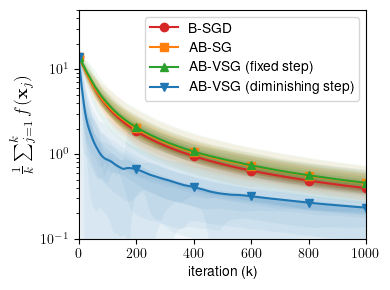

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.array(range(len(BSGD_valF_avg[0, :]))),
    BSGD_valF_avg,
    "C3",
    label="B-SGD",
    subsample=2,
    marker="o",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABSGD_valF_avg[0, :]))),
    ABSGD_valF_avg[valid_ABSGD, :],
    "C1",
    alpha=0.06,
    label="AB-SG",
    subsample=2,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABST_valF_avg[0, :]))),
    ABST_valF_avg[valid_ABST, :],
    "C2",
    alpha=0.06,
    label="AB-VSG (fixed step)",
    subsample=2,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABSTD_valF_avg[0, :]))),
    ABSTD_valF_avg[valid_ABSTD, :],
    "C0",
    alpha=0.06,
    label="AB-VSG (diminishing step)",
    subsample=2,
    marker="v",
    markevery=100,
)

ax.legend(loc="upper right", fontsize=10)
ax.set(xlabel="iteration (k)", yscale="log", ylim=[1e-1, 5e1], xlim=[0, 1000])
ax.set_ylabel(r"$\frac{1}{k}\sum_{j=1}^k f(\mathbf{x}_j)$", fontsize=13)
fig.tight_layout()
filename = "Figure/non_cvx_val_ite.pdf"
plt.savefig(filename, bbox_inches="tight")


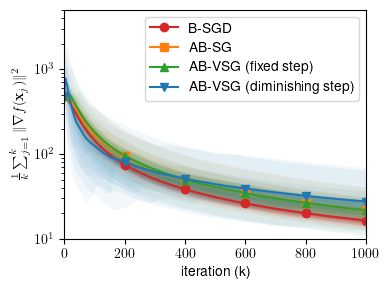

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.array(range(len(BSGD_gradF_avg[0, :]))),
    BSGD_gradF_avg,
    "C3",
    label="B-SGD",
    subsample=2,
    marker="o",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABSGD_gradF_avg[0, :]))),
    ABSGD_gradF_avg[valid_ABSGD, :],
    "C1",
    alpha=0.06,
    label="AB-SG",
    subsample=2,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABST_gradF_avg[0, :]))),
    ABST_gradF_avg[valid_ABST, :],
    "C2",
    alpha=0.06,
    label="AB-VSG (fixed step)",
    subsample=2,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABSTD_gradF_avg[0, :]))),
    ABSTD_gradF_avg[valid_ABSTD, :],
    "C0",
    alpha=0.06,
    label="AB-VSG (diminishing step)",
    subsample=2,
    marker="v",
    markevery=100,
)

ax.legend(loc="upper right", fontsize=10)
ax.set(xlabel="iteration (k)", yscale="log", ylim=[1e1, 5e3], xlim=[0, 1000])
ax.set_ylabel(r"$\frac{1}{k}\sum_{j=1}^k \| \nabla f(\mathbf{x}_j)\|^2$", fontsize=10)
fig.tight_layout()
filename = "Figure/non_cvx_grad_ite.pdf"
plt.savefig(filename, bbox_inches="tight")


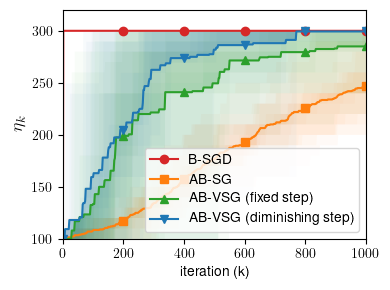

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.array(range(len(BSGD_batchg[0, :]))),
    BSGD_batchg,
    "C3",
    label="B-SGD",
    subsample=2,
    marker="o",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABSGD_batchg[0, :]))),
    ABSGD_batchg[valid_ABSGD, :],
    "C1",
    alpha=0.03,
    label="AB-SG",
    subsample=2,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABST_batchg[0, :]))),
    ABST_batchg[valid_ABST, :],
    "C2",
    alpha=0.03,
    label="AB-VSG (fixed step)",
    subsample=2,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(range(len(ABSTD_batchg[0, :]))),
    ABSTD_batchg[valid_ABSTD, :],
    "C0",
    alpha=0.03,
    label="AB-VSG (diminishing step)",
    subsample=2,
    marker="v",
    markevery=100,
)

ax.legend(loc="lower right", fontsize=10)
ax.set(xlabel="iteration (k)", yscale="linear",
       ylim=[100, 320], xlim=[0, 1000])
ax.set_ylabel(r"$\eta_k$", fontsize=13)
fig.tight_layout()
filename = "Figure/non_cvx_eta_ite.pdf"
plt.savefig(filename, bbox_inches="tight")


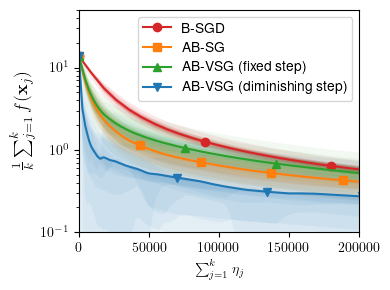

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.cumsum(BSGD_batchg, axis=1),
    BSGD_valF_avg,
    "C3",
    label="B-SGD",
    subsample=30,
    marker="o",
    markevery=10,
)
plot_multiple_line(
    ax,
    np.cumsum(ABSGD_batchg, axis=1),
    ABSGD_valF_avg[valid_ABSGD, :],
    "C1",
    alpha=0.06,
    label="AB-SG",
    subsample=30,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(ABST_batchg, axis=1),
    ABST_valF_avg[valid_ABST, :],
    "C2",
    alpha=0.06,
    label="AB-VSG (fixed step)",
    subsample=30,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(ABSTD_batchg, axis=1),
    ABSTD_valF_avg[valid_ABSTD, :],
    "C0",
    alpha=0.06,
    label="AB-VSG (diminishing step)",
    subsample=30,
    marker="v",
    markevery=100,
)

ax.legend(loc="upper right", fontsize=10)
ax.set(xlabel=r"$\sum_{j=1}^k \eta_j$",
       yscale="log", ylim=[1e-1, 5e1], xlim=[0, 2e5])
ax.set_ylabel(r"$\frac{1}{k}\sum_{j=1}^k f(\mathbf{x}_j)$", fontsize=13)
fig.tight_layout()
filename = "Figure/non_cvx_val_eta.pdf"
plt.savefig(filename, bbox_inches="tight")


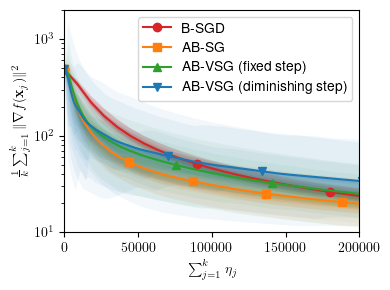

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.cumsum(BSGD_batchg, axis=1),
    BSGD_gradF_avg,
    "C3",
    label="B-SGD",
    subsample=30,
    marker="o",
    markevery=10,
)
plot_multiple_line(
    ax,
    np.cumsum(ABSGD_batchg, axis=1),
    ABSGD_gradF_avg[valid_ABSGD, :],
    "C1",
    alpha=0.06,
    label="AB-SG",
    subsample=30,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(ABST_batchg, axis=1),
    ABST_gradF_avg[valid_ABST, :],
    "C2",
    alpha=0.06,
    label="AB-VSG (fixed step)",
    subsample=30,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.cumsum(ABSTD_batchg, axis=1),
    ABSTD_gradF_avg[valid_ABSTD, :],
    "C0",
    alpha=0.06,
    label="AB-VSG (diminishing step)",
    subsample=30,
    marker="v",
    markevery=100,
)

ax.legend(loc="upper right", fontsize=10)
ax.set(xlabel=r"$\sum_{j=1}^k \eta_j$",
       yscale="log", ylim=[1e1, 2e3], xlim=[0, 2e5])
ax.set_ylabel(r"$\frac{1}{k}\sum_{j=1}^k \| \nabla f(\mathbf{x}_j)\|^2$", fontsize=10)
fig.tight_layout()
filename = "Figure/non_cvx_grad_eta.pdf"
plt.savefig(filename, bbox_inches="tight")


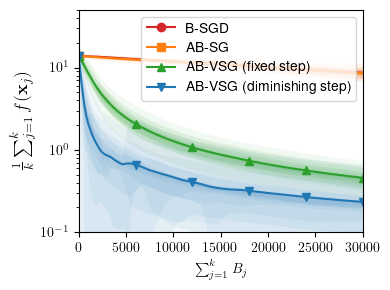

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.array(np.arange(len(BSGD_valF_avg[0, :])) * 1000),
    BSGD_valF_avg,
    "C3",
    label="B-SGD",
    subsample=2,
    marker="o",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(np.arange(len(ABSGD_valF_avg[0, :])) * 1000),
    ABSGD_valF_avg[valid_ABSGD, :],
    "C1",
    alpha=0.06,
    label="AB-SG",
    subsample=2,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(np.arange(len(ABST_valF_avg[0, :])) * 30),
    ABST_valF_avg[valid_ABST, :],
    "C2",
    alpha=0.06,
    label="AB-VSG (fixed step)",
    subsample=2,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(np.arange(len(ABSTD_valF_avg[0, :])) * 30),
    ABSTD_valF_avg[valid_ABSTD, :],
    "C0",
    alpha=0.06,
    label="AB-VSG (diminishing step)",
    subsample=2,
    marker="v",
    markevery=100,
)

ax.legend(loc="upper right", fontsize=10)
ax.set(xlabel=r"$\sum_{j=1}^k B_j$", yscale="log",
       ylim=[1e-1, 5e1], xlim=[0, 3e4])
ax.set_ylabel(r"$\frac{1}{k}\sum_{j=1}^k f(\mathbf{x}_j)$", fontsize=13)
fig.tight_layout()
filename = "Figure/non_cvx_val_batch.pdf"
plt.savefig(filename, bbox_inches="tight")


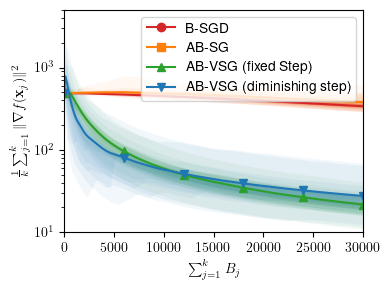

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

plot_multiple_line(
    ax,
    np.array(np.arange(len(BSGD_gradF_avg[0, :])) * 1000),
    BSGD_gradF_avg,
    "C3",
    label="B-SGD",
    subsample=2,
    marker="o",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(np.arange(len(ABSGD_gradF_avg[0, :])) * 1000),
    ABSGD_gradF_avg[valid_ABSGD, :],
    "C1",
    alpha=0.06,
    label="AB-SG",
    subsample=2,
    marker="s",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(np.arange(len(ABST_gradF_avg[0, :])) * 30),
    ABST_gradF_avg[valid_ABST, :],
    "C2",
    alpha=0.06,
    label="AB-VSG (fixed Step)",
    subsample=2,
    marker="^",
    markevery=100,
)
plot_multiple_line(
    ax,
    np.array(np.arange(len(ABSTD_gradF_avg[0, :])) * 30),
    ABSTD_gradF_avg[valid_ABSTD, :],
    "C0",
    alpha=0.06,
    label="AB-VSG (diminishing step)",
    subsample=2,
    marker="v",
    markevery=100,
)

ax.legend(loc="upper right", fontsize=10)
ax.set(xlabel=r"$\sum_{j=1}^k B_j$", yscale="log",
       ylim=[1e1, 5e3], xlim=[0, 3e4])
ax.set_ylabel(r"$\frac{1}{k}\sum_{j=1}^k \| \nabla f(\mathbf{x}_j)\|^2$", fontsize=10)
fig.tight_layout()
filename = "Figure/non_cvx_grad_batch.pdf"
plt.savefig(filename, bbox_inches="tight")
